In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')
pd.set_option('display.max_columns', None)

/Users/varnika/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/gw/xg9wcgln7x1f2k7qpz6vkm_c0000gn/T/ipykernel_38787/1522025319.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')


In [2]:
heatwave_exposure_vars = [
    "avg_tmax_annual",      # average annual max temperature
    "lpa_tmax_90th_temp",   # 90th percentile of max temp (long-period average)
    "avg_tmin_annual",      # (optional) average annual min temperature
    "aridity",              # aridity index
    "cdi_value",            # dryness index (if it matches your definition)
    "rainfall_2020",        # (optional) might indicate dryness if low
    "coef_variation",       # variation in rainfall (areas more prone to dryness extremes)
    "total_rad"             # total solar radiation (higher radiation => more heat stress)
]


In [3]:
import pandas as pd

id_cols = ["state_code", "district_code", "block_code", "FID_Key"]
heatwave_expo_cols = id_cols + heatwave_exposure_vars

heatwave_expo_df = df[heatwave_expo_cols].copy()

# Check for missing values
print(heatwave_expo_df.isna().sum())


state_code            0
district_code         0
block_code            0
FID_Key               0
avg_tmax_annual       0
lpa_tmax_90th_temp    0
avg_tmin_annual       0
aridity               0
cdi_value             0
rainfall_2020         0
coef_variation        0
total_rad             0
dtype: int64


In [4]:
from sklearn.preprocessing import RobustScaler

Rscaler = RobustScaler()

# Only scale the chosen exposure columns
features_only = heatwave_expo_df[heatwave_exposure_vars].astype(float).values
features_scaled = Rscaler.fit_transform(features_only)

# Create a scaled DataFrame
expo_scaled = pd.DataFrame(features_scaled, 
                           columns=heatwave_exposure_vars, 
                           index=heatwave_expo_df.index)

# Attach scaled columns back
for col in heatwave_exposure_vars:
    heatwave_expo_df[col + "_scaled"] = expo_scaled[col]


In [6]:
from sklearn.decomposition import PCA
import numpy as np

expo_pca_vars = [c for c in heatwave_expo_df.columns if c.endswith("_scaled")]
X_expo = heatwave_expo_df[expo_pca_vars].astype(float)

pca = PCA()
pca.fit(X_expo)

# Summarize variance
pcaSummary_heat_expo = pd.DataFrame({
    '% variance': pca.explained_variance_ratio_,
    'Cumulative %': np.cumsum(pca.explained_variance_ratio_)
})
print(pcaSummary_heat_expo.round(3))


   % variance  Cumulative %
0       0.545         0.545
1       0.216         0.761
2       0.107         0.868
3       0.067         0.935
4       0.044         0.979
5       0.011         0.989
6       0.010         0.999
7       0.001         1.000


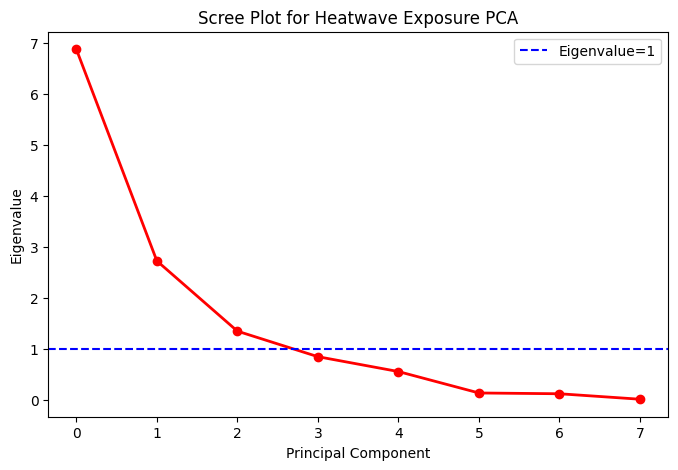

In [7]:
import matplotlib.pyplot as plt

eigenvalues = pca.explained_variance_
xvals = np.arange(len(eigenvalues))  # 0..(n-1) for each PC

plt.figure(figsize=(8,5))
plt.plot(xvals, eigenvalues, 'ro-', linewidth=2)
plt.title("Scree Plot for Heatwave Exposure PCA")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.axhline(y=1, color='b', linestyle='--', label="Eigenvalue=1")
plt.xticks(xvals)
plt.legend()
plt.show()


In [8]:
n_components = 3 
pca_n = PCA(n_components=n_components)
X_expo_pca = pca_n.fit_transform(X_expo)

pca_weights = pcaSummary_heat_expo['% variance'][:n_components]

# Add PC columns to DataFrame
for i in range(n_components):
    heatwave_expo_df[f"HeatExp_PC{i+1}"] = X_expo_pca[:, i]

# Weighted sum => "Heatwave_Exposure_Index"
heatwave_expo_df["Heatwave_Exposure_Index"] = 0
for i in range(n_components):
    heatwave_expo_df["Heatwave_Exposure_Index"] += (
        pca_weights.iloc[i] * heatwave_expo_df[f"HeatExp_PC{i+1}"]
    )

print(heatwave_expo_df[["block_code", "Heatwave_Exposure_Index"]].head())
print(heatwave_expo_df["Heatwave_Exposure_Index"].describe())


   block_code  Heatwave_Exposure_Index
0        6498                 0.848971
1        6492                 2.674879
2        4689                -1.754901
3        4690                -1.506098
4        4692                -1.430553
count    5.815000e+03
mean    -5.865185e-17
std      1.478121e+00
min     -2.195914e+00
25%     -8.761790e-01
50%     -3.017716e-01
75%      3.041464e-01
max      8.401881e+00
Name: Heatwave_Exposure_Index, dtype: float64


In [9]:
loadings_expo = pd.DataFrame(
    pca_n.components_.T,
    index=expo_pca_vars,
    columns=[f"PC{i+1}" for i in range(n_components)]
)
print(loadings_expo)


                                PC1       PC2       PC3
avg_tmax_annual_scaled    -0.591185  0.096058  0.042785
lpa_tmax_90th_temp_scaled -0.624796  0.107711  0.024332
avg_tmin_annual_scaled    -0.411771  0.295180  0.028185
aridity_scaled             0.266485  0.595986  0.056834
cdi_value_scaled           0.005697 -0.027457  0.249979
rainfall_2020_scaled       0.136989  0.591686  0.125947
coef_variation_scaled     -0.018613 -0.420851  0.063269
total_rad_scaled           0.020383 -0.094235  0.954567
